# MAP convergence diagnostic

In [1]:
import hypothesis
import numpy as np
import glob
import matplotlib.pyplot as plt
import torch
import warnings
import plotting
import palettable

from hypothesis.stat import highest_density_level
from hypothesis.visualization.util import make_square
from matplotlib.colors import LogNorm
from matplotlib import rc
from ratio_estimation import RatioEstimator
from util import load_ratio_estimator
from tqdm import tqdm

In [2]:
# hypothesis.disable_gpu()

hypothesis.accelerator

device(type='cuda')

## Globals

In [3]:
from util import Prior
from util import MarginalizedAgePrior

prior = Prior()                                  # Prior over the full paramater space
prior_marginalized = MarginalizedAgePrior()      # Prior over the WDM mass
datadir = "../experiment-simulations/data"       # Root directory containing the generated and observed data
phi = np.load(datadir + "/phi-cut.npy")          # Linear angle

# 2D posterior extent
extent = [ # I know, this isn't very nice :(
    prior.low[0].item(), prior.high[0].item(),
    prior.low[1].item(), prior.high[1].item()]

# Contour labels
clabels = [
    r"${99.99994}\%$",
    r"${99.993}\%$",
    r"${99.7}\%$",
    r"${95}\%$",
    r"${68}\%$"]

## Notebook utilities

In [4]:
def draw_contours(ax, pdf, resolution=100):
    # Compute the contour levels
    p = torch.from_numpy(pdf)
    level_1sigma = highest_density_level(p, 0.68)
    level_2sigma = highest_density_level(p, 0.95)
    level_3sigma = highest_density_level(p, 0.997)
    level_4sigma = highest_density_level(p, 0.99993)
    level_5sigma = highest_density_level(p, 0.9999994)
    levels = [
        level_5sigma,
        level_4sigma,
        level_3sigma,
        level_2sigma,
        level_1sigma]
    # Draw the levels
    masses = torch.linspace(prior.low[0], prior.high[0] - 0.01, resolution).view(-1, 1)
    masses = masses.to(hypothesis.accelerator)
    ages = torch.linspace(prior.low[1], prior.high[1] - 0.01, resolution).view(-1, 1)
    ages = ages.to(hypothesis.accelerator)
    grid_ages, grid_masses = torch.meshgrid(masses.view(-1), ages.view(-1))
    c = ax.contour(grid_ages.cpu().numpy(), grid_masses.cpu().numpy(), pdf, levels, colors="white")
    fmt = {}
    for l, s in zip(c.levels, clabels):
        fmt[l] = s
    ax.clabel(c, c.levels, inline=True, fmt=fmt)

In [5]:
def plot_2d_posterior(figure, ax, pdf, mass, age):
    # Create the main plot
    ax.minorticks_on()
    resolution = len(pdf)
    cmap = palettable.cmocean.sequential.Ice_20.mpl_colormap
    cmap = palettable.scientific.sequential.Oslo_3.mpl_colormap
    im = ax.imshow(pdf.T + 1, norm=LogNorm(), alpha=.75, interpolation="bilinear", extent=extent, origin="lower", cmap=cmap)
    ax.scatter(mass, age, s=150, marker='*', c="#ff4747", alpha=1.0, zorder=10)
    ax.set_xlabel(r"$m_{\textsc{wdm}}$")
    ax.set_ylabel("Stream age in Gyr")
    draw_contours(ax, pdf, resolution=resolution)
    ax.grid(True, which="both", alpha=.15, zorder=0, color="white")
    make_square(ax)
    
    return im

In [6]:
@torch.no_grad()
def compute_2d_pdf(r, density, resolution=100):
    masses = torch.linspace(prior.low[0], prior.high[0] - 0.01, resolution).view(-1, 1)
    masses = masses.to(hypothesis.accelerator)
    ages = torch.linspace(prior.low[1], prior.high[1] - 0.01, resolution).view(-1, 1)
    ages = ages.to(hypothesis.accelerator)
    grid_masses, grid_ages = torch.meshgrid(masses.view(-1), ages.view(-1))
    inputs = torch.cat([grid_masses.reshape(-1,1), grid_ages.reshape(-1, 1)], dim=1)
    densities = density.view(1, -1).repeat(resolution ** 2, 1)
    densities = densities.to(hypothesis.accelerator)
    log_ratios = r.log_ratio(inputs=inputs, outputs=densities)
    log_posterior = prior.log_prob(inputs).sum(dim=1).view(-1, 1) + log_ratios
    pdf = log_posterior.exp()
    map_index = torch.argmax(pdf)
    max_inputs = inputs[map_index]
    map_mass = max_inputs[0].item()
    map_age = max_inputs[1].item()
    
    return pdf.view(resolution, resolution), map_mass, map_age

## Loading the pretrained ratio estimators

In [7]:
query = "out/coverage/4096/not-marginalized/selu/ratio-estimator-resnet-50*/best-model.th"
r = load_ratio_estimator(query)

In [8]:
len(r.estimators)

6

## Diagnostic

In [9]:
query = datadir + "/nominal/block-00008"
paths = glob.glob(query)
base = paths[np.random.randint(0, len(paths))]

In [10]:
phi = np.load(base + "/phi-cut.npy")
age = np.load(base + "/ages.npy")[0]
mass = np.load(base + "/masses.npy")[0]
densities = torch.from_numpy(np.load(base + "/density-contrasts-cut-noised.npy")).float()
densities = densities.to(hypothesis.accelerator)

In [11]:
@torch.no_grad()
def compute(n, resolution=100):
    # Initialize the pdf
    final_pdf = torch.ones(resolution, resolution).to(hypothesis.accelerator)
    final_pdf /= final_pdf.sum()
    indices = np.random.randint(0, len(densities), size=n)
    #indices = np.arange(n)   
    for index in tqdm(indices):
        density = densities[index]
        pdf, _, _ = compute_2d_pdf(r, density, resolution=resolution)
        pdf /= pdf.sum()
        final_pdf *= pdf
        final_pdf /= final_pdf.sum()
        
    return final_pdf 

In [12]:
pdf_1 = compute(1, resolution=100).cpu().numpy()
pdf_10 = compute(10, resolution=100).cpu().numpy()
pdf_100 = compute(100, resolution=100).cpu().numpy()
pdf_1000 = compute(1000, resolution=100).cpu().numpy()

100%|██████████| 1000/1000 [1:08:54<00:00,  4.13s/it]


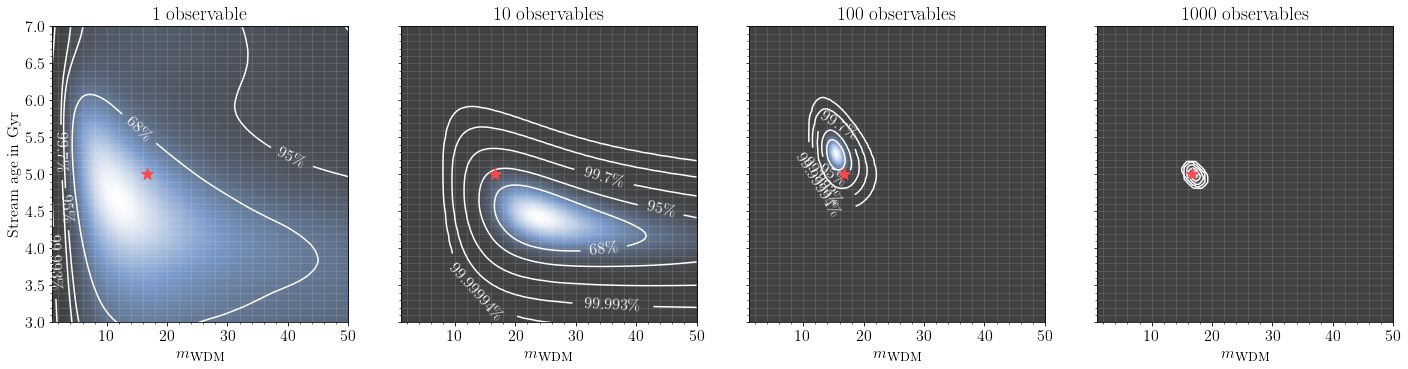

In [13]:
figure, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

# Plot 1
ax = axes[0]
plot_2d_posterior(figure, ax, pdf_1, mass, age)
ax.set_title("1 observable")

# Plot 2
ax = axes[1]
plot_2d_posterior(figure, ax, pdf_10, mass, age)
ax.set_ylabel(None)
ax.set_title("10 observables")

# Plot 3
ax = axes[2]
plot_2d_posterior(figure, ax, pdf_100, mass, age)
ax.set_ylabel(None)
ax.set_title("100 observables")

# Plot 4
ax = axes[3]
plot_2d_posterior(figure, ax, pdf_1000, mass, age)
ax.set_ylabel(None)
ax.set_title("1000 observables")

# Full figure
figure.tight_layout()
figure.savefig("plots/diagnostic_map_convergence.pdf", bbox_inches='tight')
figure.show()

## Animation

In [ ]:
from celluloid import Camera

figure, ax = plt.subplots(1, 1, figsize=(5, 5))
camera = Camera(figure)

n = 250
res = 100
final_pdf = torch.ones(res, res).to(hypothesis.accelerator)
final_pdf /= final_pdf.sum()
indices = np.arange(n)
for index in tqdm(indices):
    # Compute the pdf
    density = densities[index]
    pdf, _, _ = compute_2d_pdf(r, density, resolution=res)
    pdf /= pdf.sum()
    final_pdf *= pdf
    final_pdf /= final_pdf.sum()
    # Update the figure
    plot_2d_posterior(figure, ax, final_pdf.cpu().numpy(), mass, age)
    camera.snap()

In [ ]:
from IPython.display import HTML

animation = camera.animate(interval=50, blit=True)
HTML(animation.to_html5_video())

In [ ]:
animation.save("plots/diagnostic_map_convergence.mp4",
    dpi=100,
    savefig_kwargs={
        "frameon": False,
        "pad_inches": 0})